<a href="https://colab.research.google.com/github/iannickgagnon/software_estimation_analysis_1_2023/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# General imports
import numpy as np
import seaborn as sns
import scipy.stats as stats
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Notebook-specific imports
from IPython.display import display
from IPython.display import Math

In [76]:
def get_data() -> Tuple[np.ndarray, np.ndarray]:
  """
  Returns the independent and dependent variables in vectors sorted along x.

  Returns:
      Tuple[np.ndarray, np.ndarray]: A tuple containing two numpy arrays.
  """

  x = np.array([4300, 1600, 200, 200, 1400, 150, 200, 250, 275, 300, 20, 50, 180, 200, 25, 65, 100, 180, 200, 300, 10, 50])
  y = np.array([8300, 2300, 2100, 1300, 500, 500, 400, 400, 350, 300, 200, 200, 220, 200, 100, 100, 100, 150, 150, 150, 20, 50])

  # Ged sorted indexes
  idx = np.argsort(x, axis=0)

  return x[idx].reshape(-1, 1), y[idx].reshape(-1, 1)

In [77]:
def model_get_slope_intercept(model: LinearRegression) -> Tuple[float, float]:
  """
  Get the slope and intercept of a given linear regression model.

  Args:
      model (LinearRegression): A fitted LinearRegression model.

  Returns:
      Tuple[float, float]: The slope and intercept of the model.
  """

  slope = model.coef_[0][0]
  intercept = model.intercept_[0]

  return slope, intercept

In [88]:
def calculate_mmre(actual_values: np.ndarray, predicted_values: np.ndarray) -> float:
    """
    Calculates the mean magnitude of relative error (MMRE) between actual and predicted values.

    Args:
        actual_values (np.ndarray): The actual (observed) values.
        predicted_values (np.ndarray): The predicted values.

    Returns:
        float: The MMRE value.
    """
    
    # Calculate absolute errors
    absolute_errors = np.abs(actual_values - predicted_values)

    # Calculate relative errors
    relative_errors = absolute_errors / actual_values

    # Calculate MMRE
    mmre = np.mean(relative_errors)

    return mmre

In [115]:
def calculate_total_sum_of_squares(y: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the total sum of squares (TSS) for a given linear regression model output.

    Args:
        y (np.ndarray): Observed values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: The TSS value.
    """

    # Get the mean of the dependent variable
    y_mean = np.mean(y)

    # Calculate the TSS
    tss = np.sum((y - y_mean)**2)

    return tss

Plot the regression model trained on the raw data.

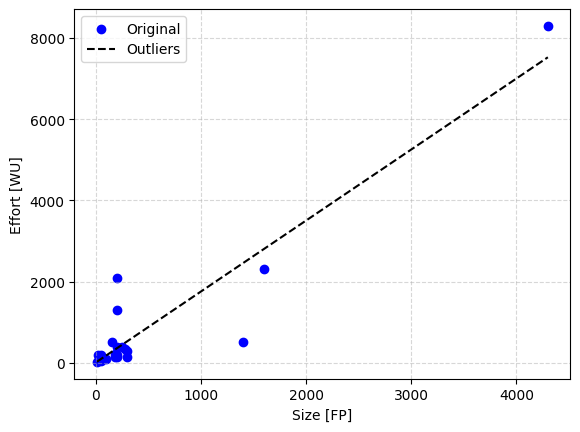

Regression equation : 


<IPython.core.display.Math object>


MMRE = 0.81

r-squared = 0.8646


In [102]:
def generate_plot_0():

  # Get the original data 
  x_original, y_original = get_data()

  # Build vanilla model
  model_original = LinearRegression().fit(x_original, y_original)

  # Get the vanilla model's prediction
  y_pred = model_original.predict(x_original)

  # Create plots
  plt.scatter(x_original, y_original, color='b')
  plt.plot(x_original, y_pred, '--k')

  # Add axis labels
  plt.xlabel('Size [FP]')
  plt.ylabel('Effort [WU]')

  # Add grid lines
  plt.grid(True, linestyle='--', alpha=0.5)

  # Add legend
  plt.legend(('Original', 'Outliers', 'Regression'))

  # Show plot
  plt.show()

  # Show regression equation
  print('Regression equation : ')
  slope, intercept = model_get_slope_intercept(model_original)
  display(Math(r'\hat{y} = ' + f'{slope:.2}x + {intercept:.2f}'))

  # Show MMRE
  mmre = calculate_mmre(y_original, y_pred)
  print(f'\nMMRE = {mmre:.2f}')

  # Show r-squared
  r_squared = model_original.score(x_original, y_original)
  print(f'\nr-squared = {r_squared:.4f}')

generate_plot_0()

We begin by using the **studentized residual method (SRM)** to identify and remove outliers one by one iteratively. Outliers are observations that differ significantly from the rest of the data. We remove them to prevent undue influence on the subsequent statistical models.
$$$$
SRM is based on the **standard error** of the residuals. We divide the residuals by their standard errors to obtain a standardized score called the **studentized residual (SR)** which is analogous to a $Z$-score for example.
$$$$
Typically, a SR greater than 2 or 3 in absolute value is considered an outlier.
$$$$
For the $i$-th, observation, we calculate the following residual where $y_i$ is the observed value and $\hat{y}_i$ is the value predicted by the model :
$$$$
$$e_i = y_i - \hat{y}_i$$
$$$$
Then we calculate the standard error :
$$$$
$$SE = \sqrt{\frac{SSE}{n - 2}}$$
$$$$
The studentized residual is calculated as follows :
$$$$
$$t_i = \frac{e_i}{SE\sqrt{1-h_{ii}}}$$
$$$$
The value $h_{ii}$ is the $i$-th diagonal element of the projection matrix which is calculated as follows :
$$$$
$$H = X(X^TX)^{-1}X^T$$
$$$$
These values are sometime called *influence* or *leverage*. Values with leverage can have significant impact on the estimated regression coefficients. SRM takes this value into consideration to identify outliers.

In [78]:
def build_model_remove_outliers(x: np.ndarray, y: np.ndarray) -> \
  Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LinearRegression]:
  """
  Builds a linear regression model with outliers removed using the studentized residual method.

  Args:
      x (np.ndarray): The independent variable (i.e., size).
      y (np.ndarray): The dependent variable (i.e., effort).

  Returns:
      (Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LinearRegression]):
          A tuple containing:
          - The independent variable after removing outliers.
          - The dependent variable after removing outliers.
          - The x-value of each removed outlier.
          - The y-values of each removed outlier.
          - The resulting linear regression model trained on the data with no outliers.
  """

  # Make local copies of input vectors
  x_clean = np.copy(x)
  y_clean = np.copy(y)

  # Studentized residual threshold
  SR_THRESHOLD = 2.0

  # Create linear regression model
  model = LinearRegression().fit(x_clean, y_clean)

  # Get predictions from model
  y_pred = model.predict(x_clean)

  # Calculate model residuals
  residuals = y_clean - y_pred

  # Calculate residuals statistics
  standard_deviation = np.std(residuals)
  mean = np.mean(residuals)

  # Calculate leverage values
  leverage = ((x_clean - mean)**2 / np.sum((x_clean - mean)**2))

  # Storage for removed outliers
  x_outliers = np.array([])
  y_outliers = np.array([])

  # Iterated removal of outliers until none are detected
  while True:

      # Calculate studentized residuals
      studentized_residuals = (residuals / standard_deviation) * np.sqrt(1 - leverage)
      
      # Get maximum residual value
      max_residual = np.max(np.abs(studentized_residuals))
    
      # Apply threshold
      if max_residual > SR_THRESHOLD:
          
          # Find the outlier
          i_to_remove = np.argmax(np.abs(studentized_residuals))
          
          # Store
          x_outliers = np.append(x_outliers, x_clean[i_to_remove])
          y_outliers = np.append(y_outliers, y_clean[i_to_remove])

          # Remove the next outlier
          x_clean = np.delete(x_clean, i_to_remove, axis=0)
          y_clean = np.delete(y_clean, i_to_remove, axis=0)
          
          # Update model
          model = LinearRegression().fit(x_clean, y_clean)
          
          # Calculate new residuals
          residuals = y_clean - model.predict(x_clean)
          
          # Calculate residuals statistics
          standard_deviation = np.std(residuals)
          mean = np.mean(residuals)

          # Calculate leverage
          leverage = ((x_clean - mean)**2 / np.sum((x_clean - mean)**2))
      
      else:

          # Procedure ends when no outliers are found
          break

  # Fit the final model and print the coefficients
  model_no_outliers = LinearRegression().fit(x_clean, y_clean)

  return x_clean, y_clean, x_outliers, y_outliers, model_no_outliers

We plot the cleaned data points in blue along with the removed outliers in red. The regression line of the model trained on the clean data is also shown in black. The regression equation is printed below the graph.

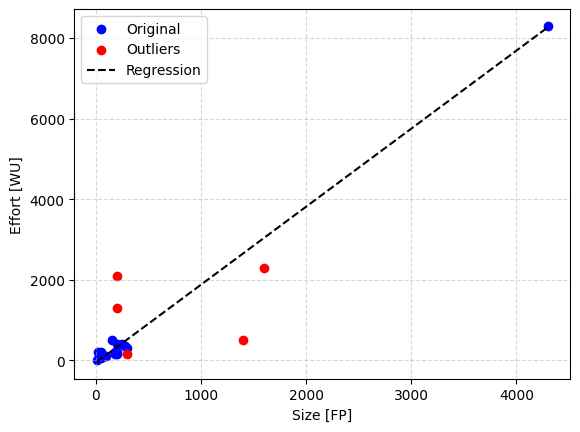

Regression equation : 


<IPython.core.display.Math object>


MMRE = 0.69

r-squared = 0.9950


In [116]:
def generate_plot_1():

  # Get the original data 
  x_original, y_original = get_data()

  # Remove outliers and build model
  x_clean, y_clean, x_outliers, y_outliers, model_no_outliers = build_model_remove_outliers(x_original, y_original)

  # Get the clean model's prediction
  y_pred = model_no_outliers.predict(x_clean)

  # Create plots
  plt.scatter(x_clean, y_clean, color='b')
  plt.scatter(x_outliers, y_outliers, color='r')
  plt.plot(x_clean, y_pred, '--k')

  # Add axis labels
  plt.xlabel('Size [FP]')
  plt.ylabel('Effort [WU]')

  # Add grid lines
  plt.grid(True, linestyle='--', alpha=0.5)

  # Add legend
  plt.legend(('Original', 'Outliers', 'Regression'))

  # Show plot
  plt.show()

  # Show regression equation
  print('Regression equation : ')
  slope, intercept = model_get_slope_intercept(model_no_outliers)
  display(Math(r'\hat{y} = ' + f'{slope:.2}x{intercept:.2f}'))

  # Show MMRE
  mmre = calculate_mmre(y_clean, y_pred)
  print(f'\nMMRE = {mmre:.2f}')

  # Show r-squared
  r_squared = model_no_outliers.score(x_clean, y_clean)
  print(f'\nr-squared = {r_squared:.4f}')

generate_plot_1()

We plot the model with the $y$-outliers removed named `Regression 1` on the legend and the same model, but with the rightmost observation removed named `Regression 2` on the legend. The reason for this is that the rightmost point at $(4300, 8300)$ exerts too much influence on the model. This can be seen directly on the graph by comparing the two slopes.

In [80]:
def model_data_remove_rightmost(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """
  Removes the rightmost point from the input data.

  Args:
    x (np.ndarray): The independent variable data.
    y (np.ndarray): The dependent variable data.

  Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing:
      - The independent variable data with the rightmost point removed.
      - The dependent variable data with the rightmost point removed.
  """

  # Make local copies of data vectors
  x_removed_rightmost = np.copy(x)
  y_removed_rightmost = np.copy(y)

  # Get the index of the rightmost point assuming the values are not sorted
  i_size_max = np.argmax(x_removed_rightmost)

  # Remove rightmost point
  x_removed_rightmost = np.delete(x_removed_rightmost, i_size_max).reshape(-1, 1)
  y_removed_rightmost = np.delete(y_removed_rightmost, i_size_max).reshape(-1, 1)

  return x_removed_rightmost, y_removed_rightmost

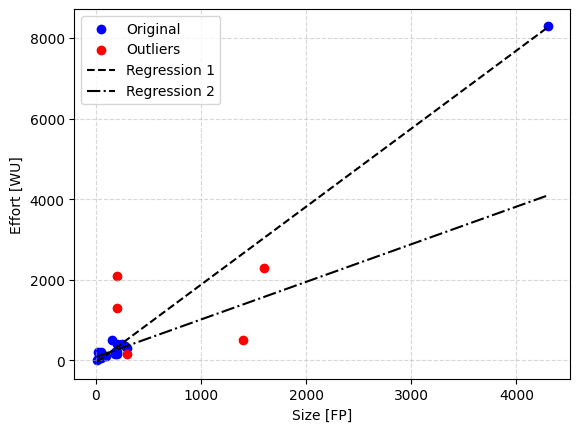

Regression equation 1 : 


<IPython.core.display.Math object>


MMRE_1 = 0.69
R2_1 = 0.9950
TSS_1 = 61811294

Regression equation 2 : 


<IPython.core.display.Math object>


MMRE_2 = 0.67
R2_2 = 0.4153
TSS_2 = 289200



In [121]:
def generate_plot_2():
    
  # Get the original data 
  x_original, y_original = get_data()

  # Remove outliers and build model
  x_clean, y_clean, x_outliers, y_outliers, model_no_outliers = build_model_remove_outliers(x_original, y_original)

  # Get the clean model's prediction
  y_pred = model_no_outliers.predict(x_clean)
  
  # Remove the rightmost data point
  x_removed_rightmost, y_removed_rightmost = model_data_remove_rightmost(x_clean, y_clean)

  # Build model on data with rightmost removed
  model_removed_rightmost = LinearRegression().fit(x_removed_rightmost, y_removed_rightmost)
  
  # Get new model's predictions
  y_removed_rightmost_pred = model_removed_rightmost.predict(x_removed_rightmost)
  
  # Create plots
  plt.scatter(x_clean, y_clean, color='b')
  plt.scatter(x_outliers, y_outliers, color='r')
  plt.plot(x_clean, y_pred, '--k')
  plt.plot(x_clean, model_removed_rightmost.predict(x_clean), '-.k')

  # Add axis labels
  plt.xlabel('Size [FP]')
  plt.ylabel('Effort [WU]')

  # Add grid lines
  plt.grid(True, linestyle='--', alpha=0.5)

  # Add legend
  plt.legend(('Original', 'Outliers', 'Regression 1', 'Regression 2'))

  # Show plot
  plt.show()

  # Show regression equations, MMRE, R2 and TSS (see paragraph below)
  print('Regression equation 1 : ')
  slope_1, intercept_1 = model_get_slope_intercept(model_no_outliers)
  display(Math(r'\hat{y} = ' + f'{slope_1:.2}x{intercept_1:.2f}'))
  
  mmre_1 = calculate_mmre(y_clean, y_pred)
  print(f'\nMMRE_1 = {mmre_1:.2f}')
  
  r_squared_1 = model_no_outliers.score(x_clean, y_clean)
  print(f'R2_1 = {r_squared_1:.4f}')

  tss_1 = int(calculate_total_sum_of_squares(y_clean, y_pred))
  print(f'TSS_1 = {tss_1}\n')

  print('Regression equation 2 : ')
  slope_2, intercept_2 = model_get_slope_intercept(model_removed_rightmost)
  display(Math(r'\hat{y} = ' + f'{slope_2:.2}x + {intercept_2:.2f}'))

  mmre_2 = calculate_mmre(y_removed_rightmost, y_removed_rightmost_pred)
  print(f'\nMMRE_2 = {mmre_2:.2f}')

  r_squared_2 = model_removed_rightmost.score(x_removed_rightmost, y_removed_rightmost)
  print(f'R2_2 = {r_squared_2:.4f}')

  tss_2 = int(calculate_total_sum_of_squares(y_removed_rightmost, y_removed_rightmost_pred))
  print(f'TSS_2 = {tss_2}\n')


generate_plot_2()

We note that MMRE goes from 0.69 to 0.67 when the rightmost data point is removed while $R^2$ falls sharply from 0.9950 to 0.4153. This is because of the way $R^2$ is calculated :
$$$$
$$R^2=1-\frac{RSS}{TSS}$$
$$$$
The total sum of squares ($TSS$) is highly influenced by the rightmost data point as can be inferred from our data and the following formula :
$$$$
$$TSS=\sum_{i=1}^{n}(y_i-\bar{y}^2)$$
$$$$

Plot the model trained on the cleaned data and add 95% confidence intervals :

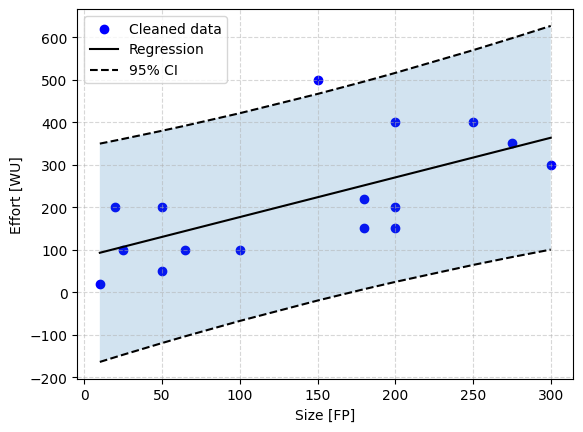

Regression equation : 


<IPython.core.display.Math object>


MMRE_1 = 0.67
R2_1 = 0.4153



In [113]:
def generate_plot_3():

  # Significance level
  ALPHA = 0.05

  # Get the original data 
  x_original, y_original = get_data()

  # Remove outliers and build model
  x_clean, y_clean, x_outliers, y_outliers, model_no_outliers = build_model_remove_outliers(x_original, y_original)

  # Remove the rightmost data point
  x_removed_rightmost, y_removed_rightmost = model_data_remove_rightmost(x_clean, y_clean)

  # Build model on data with rightmost removed
  model_removed_rightmost = LinearRegression().fit(x_removed_rightmost, y_removed_rightmost)

  # Get new model's predictions
  y_removed_rightmost_pred = model_removed_rightmost.predict(x_removed_rightmost)

  # Calculate number of observations
  n = len(x_removed_rightmost)

  # Calculate residials
  residuals = y_removed_rightmost - y_removed_rightmost_pred

  # Calculate standard error
  se = np.sqrt(np.sum(residuals ** 2) / (n - 2))

  # Calculate t-values
  t_value = stats.t.ppf(1 - ALPHA / 2, n - 2)
  
  # Calculate confidence interval widths
  ci = t_value * se * np.sqrt(1 + 1 / n + (x_removed_rightmost - np.mean(x_removed_rightmost)) ** 2 / np.sum((x_removed_rightmost - np.mean(x_removed_rightmost)) ** 2))

  # Build lower and upper confidence intervals
  lower_ci = y_removed_rightmost_pred - ci
  upper_ci = y_removed_rightmost_pred + ci

  # Create plots
  plt.scatter(x_removed_rightmost, y_removed_rightmost, color='b')
  plt.plot(x_removed_rightmost, y_removed_rightmost_pred, 'k')
  plt.plot(x_removed_rightmost, upper_ci, 'k--')
  plt.plot(x_removed_rightmost, lower_ci, 'k--')
  plt.fill_between(x_removed_rightmost.reshape(-1), lower_ci.reshape(-1), upper_ci.reshape(-1), alpha=0.2)

  # Add axis labels
  plt.xlabel('Size [FP]')
  plt.ylabel('Effort [WU]')

  # Add grid lines
  plt.grid(True, linestyle='--', alpha=0.5)

  # Add legend
  plt.legend(('Cleaned data', 'Regression', '95% CI'))

  # Show plot
  plt.show()

  # Show regression equations, MMREs and R2s
  print('Regression equation : ')
  slope_1, intercept_1 = model_get_slope_intercept(model_removed_rightmost)
  display(Math(r'\hat{y} = ' + f'{slope_1:.2}x + {intercept_1:.2f}'))
  
  mmre_1 = calculate_mmre(y_removed_rightmost, y_removed_rightmost_pred)
  print(f'\nMMRE_1 = {mmre_1:.2f}')
  
  r_squared_1 = model_removed_rightmost.score(x_removed_rightmost, y_removed_rightmost)
  print(f'R2_1 = {r_squared_1:.4f}\n')


generate_plot_3()